In [1]:
# September 2021

# Статистическое исследование

In [2]:
# ! pip install wordcloud
# ! pip install textblob
# ! pip install mlxtend
# ! pip install pingouin 

In [3]:
import pandas as pd # для работы с датафреймом
import numpy as np # для вычислений
import matplotlib.pyplot as plt # для графиков
import seaborn as sns # для графиков
from scipy.stats import norm # проверка распределения
from scipy import stats # статистический анализ
import scipy.stats as stats # статистический анализ
from mlxtend.evaluate import permutation_test # перестановочный тест
import statsmodels.stats.multicomp as mc # HDS тест для определения групп
import re # для регулярных выражений
from nltk.tokenize import RegexpTokenizer #библиотека для работы с естественным языком
import nltk # для обработки естественного языка
from nltk import word_tokenize # для деления предложений на слова   
from nltk.corpus import stopwords # для исключения стоп-слов
from wordcloud import WordCloud, STOPWORDS # для облака слов
from textblob import TextBlob # для анализа эмоций
import pingouin as pg # базовые функции библиотеки
from pingouin import welch_anova # тест Уэлча

# Введение

Как указывалось в первой главе, статистическое обследование решает две основные задачи: 

1) определеить характеристики (описать) группы данных, 
2) определить закономерности в отношениях между группами данных. 

Представим таблицу. У таблицы две оси - вертикаль (строки) и горизонталь (столбцы). Строки - это наблюдения, столбцы - это признаки. Задача статистического обследования - описать данные по каждому столбцу (признаку) и отношения между столбцами (признаками).

Машинное обучение, с этой точки зрения, является практическим применением знаний о структуре данных.

В данной главе нас будет интересовать только статистическое обследование данных. Такое обследование можно разделить на три части: 

1) визуализация данных,
2) определение метрик,
3) применение статистических тестов.

## Рекомендуемая литература (все книги, указанные ниже по тексту, также указаны здесь):

1) В. Гмурман Теория вероятностей и математическая статистика
2) Сара Бослаф Статистика для всех
3) П. Брюс Практическая статистика для специалистов Data Science

Рекомендуемые книги по математике см. [здесь](https://medium.com/data-science-with-ruslan-nazarov/книги-по-data-science-и-математике-для-начинающих-6257214d82d7)

## Онлайн-ресурсы:

1) документация по библиотеке [Pingoiun](https://pingouin-stats.org/) (также содержит описания статистических концепций, реализованных в составе библиотеки)
2) хорошее описание статистических процедур [PYTHON FOR DATA SCIENCE](https://www.pythonfordatascience.org/)


Видео-версия находится [здесь](https://www.youtube.com/watch?v=rezfN8KaJUU&list=PLu3t5v5Z6x_ScpOxerTEkFblR5JRP2-QU&index=2&t=1236s).

Дополнительный полезный код, который может быть применен в том числе к задаче статистического обследования данных, можно также найти в главе 7.

*В будущих редакциях методички*

1) будет дано более простое описание примененных тестов, а также приведены дополнительные тесты;
2) будет показан анализ временных рядов.

# Загрузка данных и общий обзор

In [4]:
# скопируйте путь к файлу из проводника Windows, но замените \ на /
# дополнительно исправим тип данных для отдельных признаков

data = pd.read_csv(
    'D:/Data Science/Проекты/Metod_Goodreads/git_goodreads/gd_clean_data.csv', 
    dtype = {'decade':'object','quarter':'object', 'tra_co':'object', 'multivolume':'object'
}) 

In [5]:
# сделаем копию наших данных и дальше будем работать только с ней

db = data.copy()
db.head()

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume
0,Harry Potter and the Half-Blood Prince (Harry ...,4.57,eng,652,2095690,27591,2000,3,1,1
1,Harry Potter and the Order of the Phoenix (Har...,4.49,eng,870,2153167,29221,2000,3,1,1
2,Harry Potter and the Chamber of Secrets (Harry...,4.42,eng,352,6333,244,2000,4,0,1
3,Harry Potter and the Prisoner of Azkaban (Harr...,4.56,eng,435,2339585,36325,2000,2,1,1
4,Harry Potter Boxed Set Books 1-5 (Harry Potte...,4.78,eng,2690,41428,164,2000,3,1,1


In [6]:
#сделаем общий осмотр наших данных

db.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10838 entries, 0 to 10837
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               10838 non-null  object 
 1   average_rating      10838 non-null  float64
 2   language_code       10838 non-null  object 
 3   num_pages           10838 non-null  int64  
 4   ratings_count       10838 non-null  int64  
 5   text_reviews_count  10838 non-null  int64  
 6   decade              10838 non-null  object 
 7   quarter             10838 non-null  object 
 8   tra_co              10838 non-null  object 
 9   multivolume         10838 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 846.8+ KB


Теперь нам надо определить, что мы хотим узнать из наших данных. Специальных целей перед нами никто не ставил, поэтому определим их самостоятельно. Что интересного могут рассказать данные? Здесь же мы сразу укажем, какими методами мы будем решать эти задачи. Обратите внимание, что не всегда мы можем заранее знать, какой метод подойдет. Например, нам нужно сначала проверить распределение на нормальность, чтобы применить корреляцию. Поэтому в этот список можно вносить изменения по ходу анализа.

Как указывалось ранее, мы можем разделить статистическое обследование на изучение группы данных и изучение отношений между группами данных. С учетом этого и разделим наши задачи.

Изучение каждой группы данных отдельно:

* Характеристики центрального положения для количественных признаков. Метод describe;
* Характеристики категориальных данных. Тот же describe;
* Какой тип распределения у средних оценок для книг, для количества страниц в книгах? (здесь не рассматривается).

Изучение отношений между группами данных:

* Как распределены книги по десятилетиям? Используем график;
* Какие книги получили высокие оценки? Используем график;
* Как распределены книги по кварталам? Используем график;
* Какие книги чаще всего издавались в рамках нашего набора данных? Используем график;
* Если у книги есть соавтор или переводчик, как это влияет на оценку? Используем дисперсионный анализ;
* От каких признаков зависит оценка книги? Используем корреляцию, дисперсионный анализ;
* Какие слова чаще всего используются в названии книги? Используем NLTK.

Начнем с характеристик центрального положения.

# Статистическое описание данных

In [7]:
# убираем в выводе экспоненту

pd.set_option('display.float_format', lambda x: '%.3f' % x) 

In [8]:
db.describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,10838.000,10838.000,10838.000,10838.000
mean,3.942,344.175,18347.883,553.075
std,0.295,238.556,113866.010,2599.330
min,1.000,11.000,0.000,0.000
25%,3.770,203.000,117.000,10.000
50%,3.960,304.000,803.500,49.000
75%,4.130,417.000,5226.750,248.000
max,5.000,6576.000,4597666.000,94265.000


In [9]:
# робастная оценка среднего

av = np.array(db['average_rating'])
stats.trim_mean(av, 0.1) 

3.9531780442804427

In [10]:
# медианное абсолютнное отклонение

db['average_rating'].mad() 

0.224434581719725

Мы можем описать каждый признак, чтобы лучше его понять.
* **average_rating**. Это средняя оценка книги. Всего значений 10838, что совпадает для всех признаков. Средняя оценка 3.942. Стандартное отклонение составляет 0.295. Однако мы дополнительно вычислили робастную оценку среднего, а также медианну для отклонений от среднего. Мы видим, что в этом случае среднее равно 3.953, а отклонение от среднего будет в пределах 0.224. В общем случае мы можем сказать, что читатели ставят оценку 3 или 4. Далее мы видим, что только 25% оценок ниже 3.77. 
* **num_pages**. Это количество страниц в книге. Мы видим, что среднее значение это 344 страниц. Однако максимальное достигает 6576 страниц. Возможно, это значение является выбросом. И возможно, что оно не одно такое. Выбросы будут рассмотрены отдельно.
* **ratings_count**. Это количество оценок. Видим, что на одну книгу в среднем приходится 18347 отзывов. Стандартное отклонение составляет 113866, что крайне много. Значит, есть книги с большим количеством оценок. Но есть и книги с 0 оценок. При этом нижние 25% значений количества оценок меньше 117. Максимальное же значение составляет 4597666, почти 5 миллионов оценок! Что это за книга?
* **text_reviews_count**. Это количество отзывов. В среднем одна книга получает 553 отзыва при среднем отклонении в 2599. Есть книги, у которых отзывы отсутствуют. При этом нижние 25% значений количества отзывов составляет 9 отзывов. Максимальное же количество составляет 94265. Совпадает ли это с максимальным количеством оценок?

In [11]:
# книга с самым большим количеством отзывов

db[db['ratings_count'] == 4597666]

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume
10077,Twilight (Twilight #1),3.590,eng,501,4597666,94265,2000,3,0,1


In [12]:
# опишем категориальные признаки

db[['title', 'language_code', 'decade', 'quarter', 'tra_co', 'multivolume']].describe() 

,title,language_code,decade,quarter,tra_co,multivolume
count,10838,10838,10838,10838,10838,10838
unique,10149,26,8,4,2,2
top,The Iliad,eng,2000,3,0,0
freq,8,8669,7332,2851,6492,8147


Видим, что у нас 10149 уникальных названий книг из 10838. 

Чаще всего встречается Anna Karenina, 8 раз. 26 различных языков, самый частый eng, 8669. 

Декад всего 13, самая частая - это 2000, на которую приходится 7332. 

Кварталов 4, самый частый 3, на него приходится 2851 книга. 

Категорий "с соавтором, переводчиком" и без, что очевидно, две: либо переводчик, соавтор есть, либо его нет. Чаще всего его нет, таких случаев 6492. 

Аналогично, либо книга является частью многотомного издания и тогда в колонке **multivolume** стоит 1, либо не является частью такого издания и тогда мы получаем 0. Как видим, у нас, как правило, не многотомные издания (их 8147).

# Визуализация данных

Мы используем визуализацию для того, чтобы "схватить" какие-то гипотезы на наших данных. Визуально человеку проще это сделать. Однако надо помнить, что размещение слишком большого количества данных на графике уменьшает этот эффект простоты. Например, на одном графике можно точками отразить распределение по двум признакам, сюда же добавить третий признак цветом точек, четвертый - размером точек, пятый - их формой. Но такой график будет крайне сложно прочитать, а значит и смысл в визуализации теряется. 

В нашем конкретном случае мы хотим установить следующее: 

1) распределение целевого признака - средняя оценка; 
2) наличие выбросов по количественным признакам; 
3) наличие взаимосвязи между признаками; 
4) соотношение категориальных данных там, где это уместно. 

Text(0.5, 1.0, 'Распределение средних оценок')

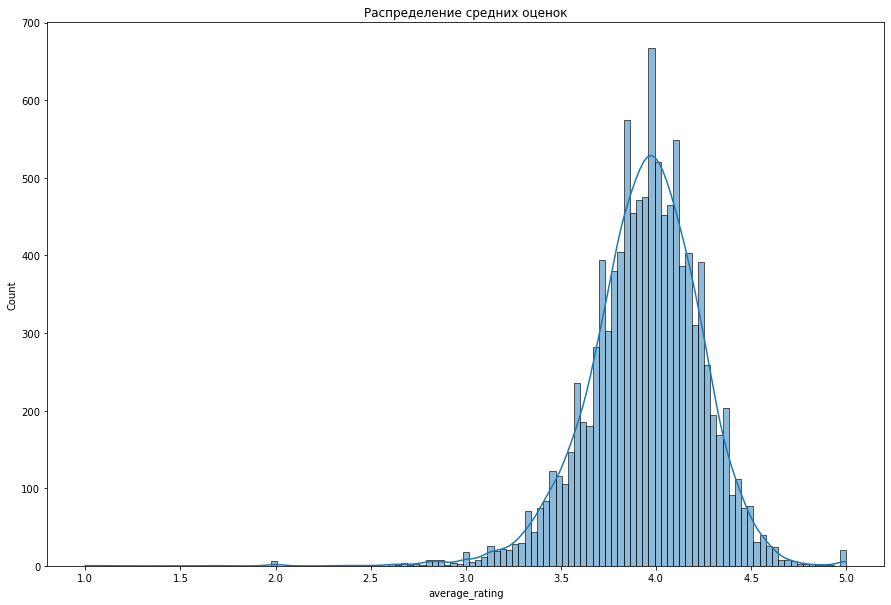

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))

# линия это плотность распределения

sns.histplot(db['average_rating'], kde=True) 
plt.title('Распределение средних оценок')

Видим, что средние оценки распределены практически нормально. Обратите внимание, что в интервалах 2.5 - 3.0 и 4.8 - 5.0 мы видим небольшие подъемы линии. При нормальном распределении этого быть не должно. Это означает, что оценки в указанных интервалах мы наблюдаем чаще, чем это предсказывает нормальное распределение. Дополнительная проверка на нормальность распределения с помощью статистических методов будет показана ниже. 

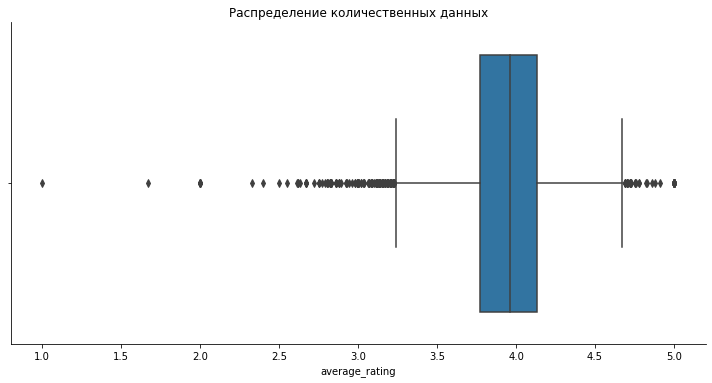

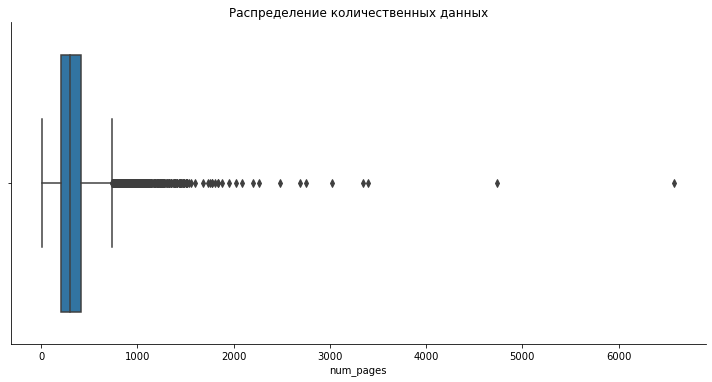

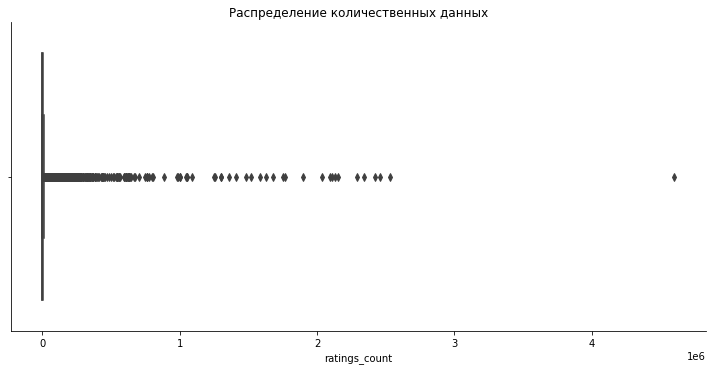

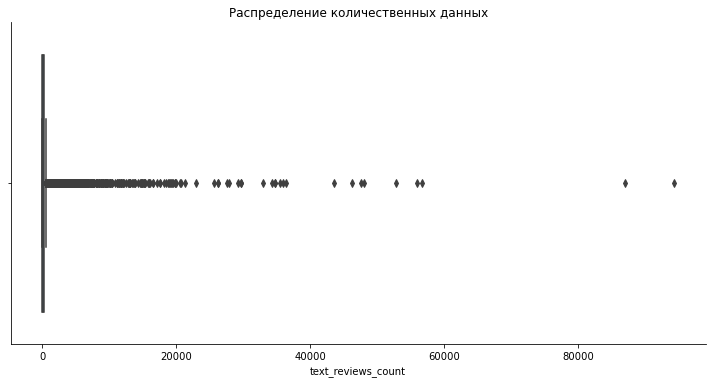

In [14]:
# стандартная проверка на выбросы

for i in ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']:
    sns.catplot(kind='box', data=db, aspect=2, x=i)
    plt.title('Распределение количественных данных')

Это - ящики с усами. Их придумал отец-основатель анализа данных Тьюки. В прямоугольнике - по середине - показана медиана. Левый край прямоугольника - это 25%-квартиль, правый край - 75%. Усы - это межквартильный размах. За пределами усов - выбросы. Ящики считаются интуитивно понятными, но это не совсем так. Поэтому давайте сделаем небольшое отступление. Главный вопрос про ящик - это почему он то сжимается, то растягивается. Почему медиана скачет от левой стороны к правой? Ведь это медиана, она должна быть посередине, нет? Все верно, почти. 

In [15]:
# создадим вектор данных

example = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) 

{'whiskers': [<matplotlib.lines.Line2D at 0x1fbec3f97c0>,
 'caps': [<matplotlib.lines.Line2D at 0x1fbec3f9eb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fbec3f9460>],
 'medians': [<matplotlib.lines.Line2D at 0x1fbec4065b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fbec406910>],
 'means': []}

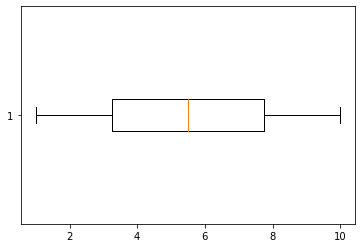

In [16]:
plt.boxplot(example, vert=False)

In [17]:
np.median(example)

5.5

In [18]:
# создадим еще один вектор данных

example1 = np.array([1, 2, 3, 4, 5, 6, 51, 53, 54, 100]) 

{'whiskers': [<matplotlib.lines.Line2D at 0x1fbec454730>,
 'caps': [<matplotlib.lines.Line2D at 0x1fbec454df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fbec4543d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1fbec4604f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fbec460850>],
 'means': []}

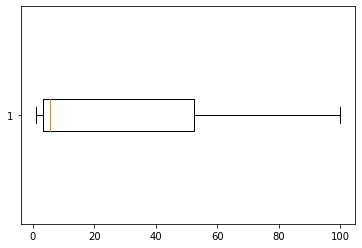

In [19]:
plt.boxplot(example1, vert=False)

In [20]:
np.median(example1)

5.5

In [21]:
# ниже мы подробно разберем, как образуются усы, а заодно и как писать функции

q1, q3 = np.percentile(example1, [25, 75])

# левый (нижний) квартиль
q1 

# правый (верхний) квартиль
q3 

# межквартильный размах
iqr = q3 - q1 
iqr

49.25

In [22]:
# левый (нижний) ус

lower_bound = q1 - (iqr * 1.5) 
lower_bound

-70.625

In [23]:
# левый (нижний) ус

upper_bound = q3 + (iqr * 1.5) 
upper_bound

126.375

Что у нас здесь произошло? Мы создали второй вектор, где заменили 7, 8, 9, 10 на  51, 53, 54, 100. Количество значений не изменилось. Не изменилась и сама медиана - она осталась 5.5. Однако линия медианы "прижалась" к левой стороне ящика. Почему? 

На оси **x** откладываются значения нашего вектора. Ось **y** показывает нам количество таких значений. В первом случае на оси **x** мы откладывали значения от 1 до 10. Во втором случае мы откладывали значения от 1 до 100. Количество значений ниже и выше медианы не изменилось, но изменился масштаб. 

Усы же строятся несколько иначе. Мы определили границы усов (lower bound, upper bound). Далее мы смотрим, а какие из имеющихся значений не выходят за границы усов. До минимального (максимального) значения наших усов в установленных границах мы и строим усы. Например, у нас граница для верхнего уса 126, но фактически у нас есть только значение 100. Мы строим ус до 100. Но граница нижнего уса у нас - 71, однако наше минимальное фактическое значение это 1, поэтому мы строим ус до 1. Поэтому и возникает разница в длине усов. 

**Совет: если вы столкнулись с трудностью в понимании какой-либо формулы, статистики и т.п., то всегда начинайте с простого случая.**

In [24]:
# применим указанный подход к нашим реальным данным

q1, q3 = np.percentile(db['average_rating'], [25, 75]) 

# межквартильный размах

iqr = q3 - q1 

# из нижней границы вычитаем полтора межквартильных размаха

lower_bound = q1 - (iqr * 1.5) 

# к верхней границе прибавляем полтора межквартильных размаха

upper_bound = q3 + (iqr * 1.5) 

In [25]:
print(lower_bound, upper_bound)

3.2300000000000004 4.67


Мы видим следующее. Усы показывают число. Пускай это будет 3.23. Это число - одна из средних оценок книги. Ниже этого числа - выбросы.

In [26]:
# пример создания функции
# x данные, которые надо проверить на выбросы

def outliers(x): 

    # мы заменили db['average_rating'] на переменную

    q1, q3 = np.percentile(x, [25, 75]) 
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)

    # результат, который возвращает функция

    return lower_bound, upper_bound 

In [27]:
data = [{'Нижний выброс': outliers(i)[0], 'Верхний выброс': outliers(i)[1]} for i in [db['average_rating'], db['num_pages'], db['ratings_count'], db['text_reviews_count']]]

In [28]:
pd.DataFrame(data, index=['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count'])

,Нижний выброс,Верхний выброс
average_rating,3.230,4.670
num_pages,-118.000,738.000
ratings_count,-7547.625,12891.375
text_reviews_count,-347.000,605.000


In [29]:
"""

# приводится для примера

# построим график парных распределений для наших количественных признаков. Так мы сможем увидеть взаимосвязи.

sns.pairplot(db) # может долго вычислять

"""

'\nПостроим график парных распределений для наших количественных признаков. Так мы сможем увидеть взаимосвязи.\n'

Сразу бросается в глаза, что есть линейная связь между количеством отзывов и количеством оценок. Но это достаточно очевидно и нас здесь не особо волнует. Мы хотим определить, от чего зависит именно средняя оценка книги. Теперь построим несколько дополнительных графиков, чтобы посмотреть, как распределяются наши данные по категориям.

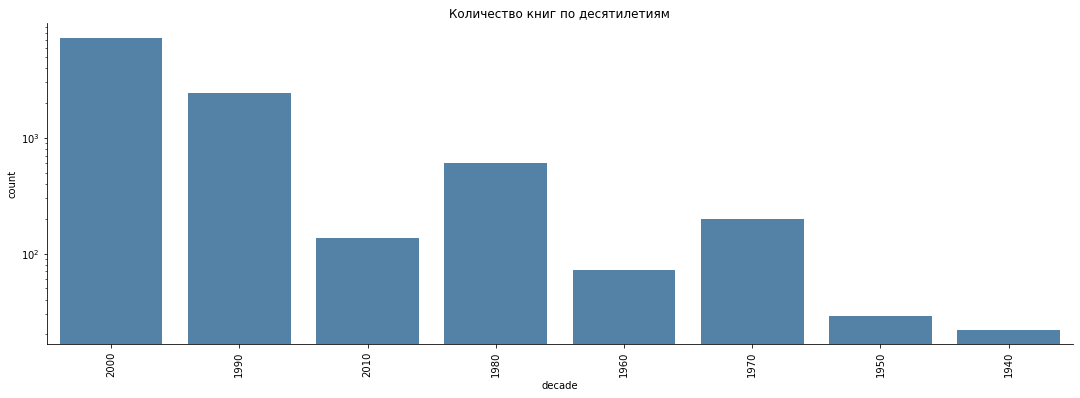

In [30]:
# посмотрим распределение книг по десятилетиям

sns.catplot(x='decade', data=db, color='steelblue', aspect=3, kind='count')

#поворачиваем подписи по оси X

plt.xticks(rotation=90) 

# используем логарифмическую шкалу

plt.yscale('log') 
plt.title('Количество книг по десятилетиям')
plt.show()

Text(0.5, 1.0, 'Распределение книг по кварталам')

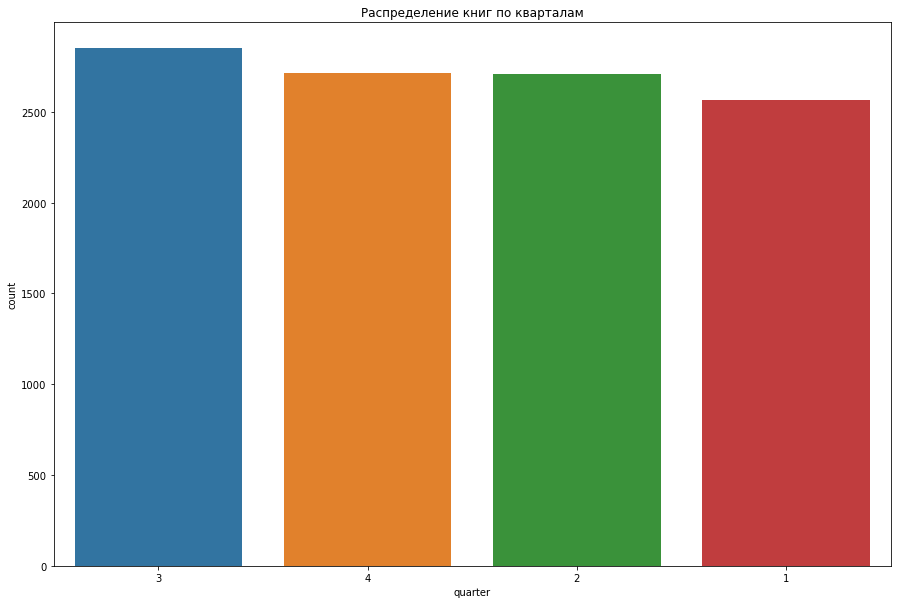

In [31]:
# распределение по кварталам

fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(x = db['quarter']) 
plt.title('Распределение книг по кварталам')

По кварталам книги распределены приблизительно одинаково. 

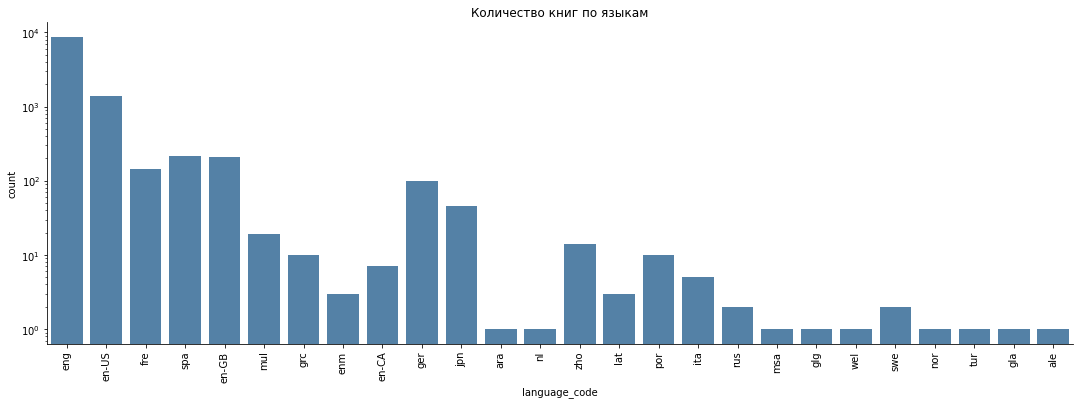

In [32]:
# посмотрим распределение книг по языкам

sns.catplot(x='language_code', data=db, color='steelblue', aspect=3, kind='count')

# поворачиваем подписи по оси X

plt.xticks(rotation=90) 

# используем логарифмическую шкалу

plt.yscale('log') 
plt.title('Количество книг по языкам')
plt.show()

Английский языка безусловный лидер. Теперь построим по тем же категориям график, который покажет связь со средними оценками

Text(0.5, 1.0, 'Средние оценки по декадам')

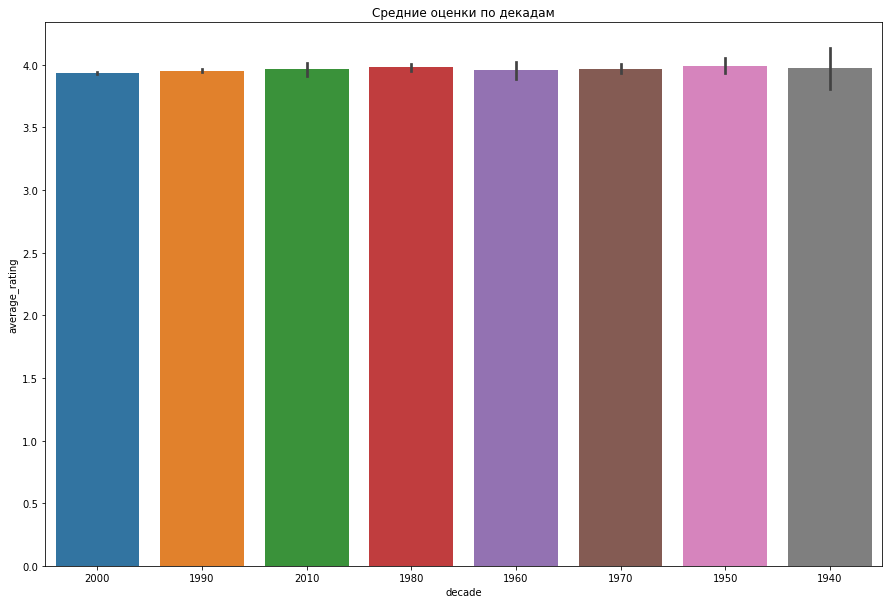

In [33]:
# распределение средних оценок по декаде издания книги, сo стандартными отклонениями

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x = db['decade'], y=db['average_rating']) 
plt.title('Средние оценки по декадам')

Видим, что оценки примерно одинаково располагаются по декадам. 

Text(0.5, 1.0, 'Средние оценки по кварталу')

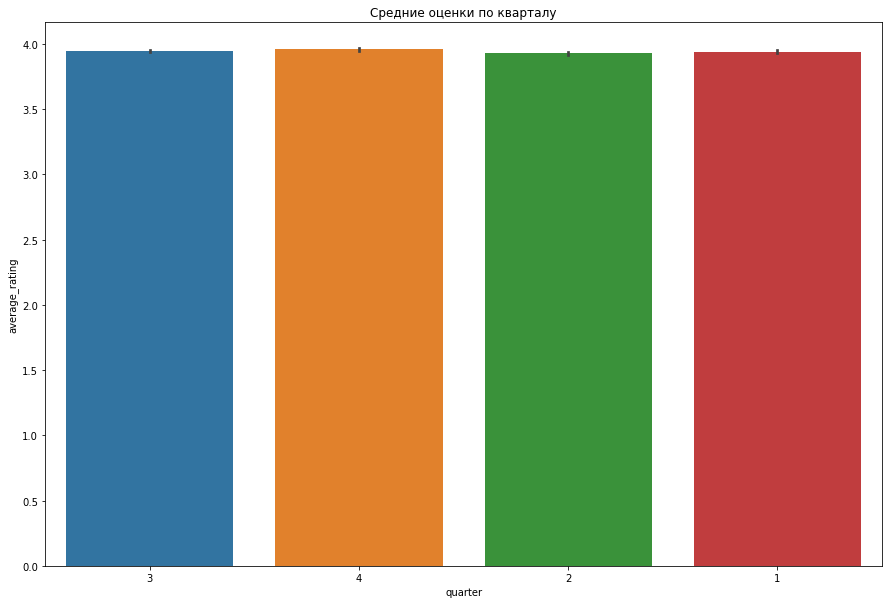

In [34]:
# распределение средних оценок по кварталу издания книги, сo стандартными отклонениями

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x = db['quarter'], y=db['average_rating']) 
plt.title('Средние оценки по кварталу')

Опять-таки получаем примерно одинаковое количество. 

Text(0.5, 1.0, 'Средние оценки по языкам')

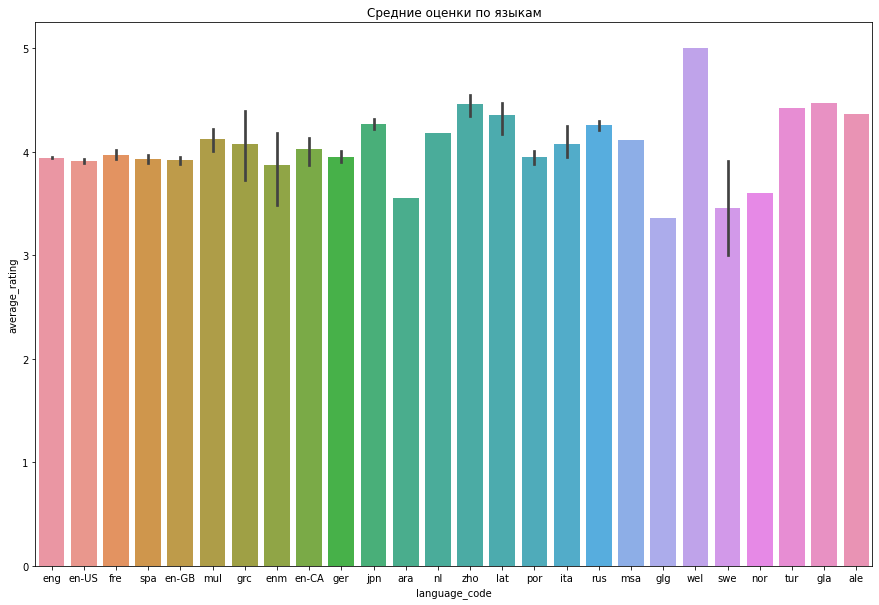

In [35]:
# распределение средних оценок по языкам издания книги, сo стандартными отклонениями

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x = db['language_code'], y=db['average_rating']) 
plt.title('Средние оценки по языкам')

Text(0.5, 1.0, 'Средние оценки по многотомности')

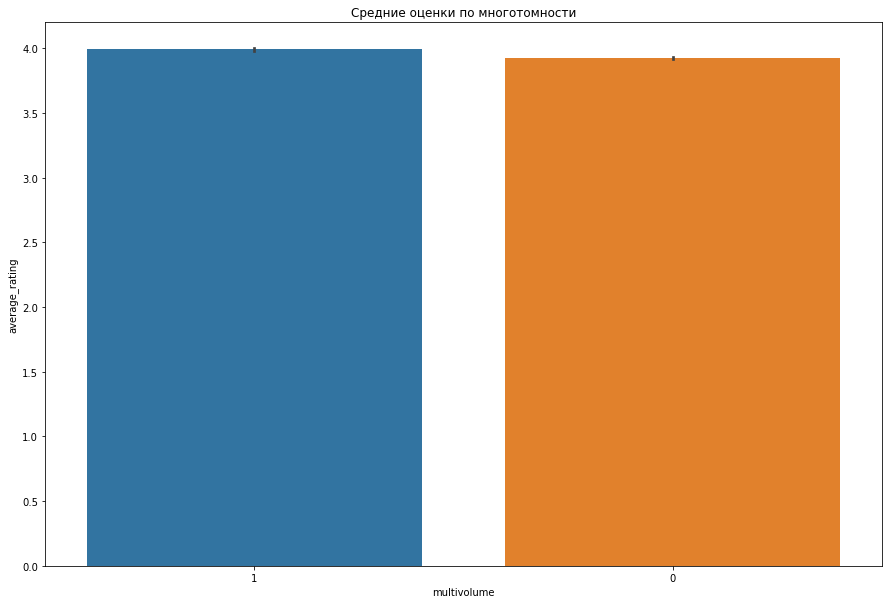

In [36]:
# распределение средних оценок по признаку многотомности, сo стандартными отклонениями

fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x = db['multivolume'], y=db['average_rating']) 
plt.title('Средние оценки по многотомности')

# Агрегирование данных

Мы используем визуализацию, чтобы упростить понимание данных. Аналогично, мы можем использовать агрегированные данные. В тех случаях, когда визуализация лишена смысла (слишком много категорий и т.п.), агрегирование поможет нам больше. 

In [37]:
# самые частые книги

db['title'].value_counts()[0:5] 

The Iliad                     8
The Odyssey                   8
Anna Karenina                 8
The Brothers Karamazov        7
The Picture of Dorian Gray    7
Name: title, dtype: int64

In [38]:
# книги с самым высоким рейтингом

db.groupby('title')['average_rating'].mean().sort_values(ascending=False)[0:10] 

title
The New Big Book of America                                                                         5.000
Bulgakov's the Master and Margarita: The Text as a Cipher                                           5.000
The Complete Theory Fun Factory: Music Theory Puzzles and Games for the Early Grades                5.000
Zone of the Enders: The 2nd Runner Official Strategy Guide                                          5.000
The Irish Anatomist: A Study of Flann O'Brien                                                       5.000
Comoediae 1: Acharenses/Equites/Nubes/Vespae/Pax/Aves                                               5.000
Colossians and Philemon: A Critical and Exegetical Commentary (International Critical Commentary)   5.000
His Princess Devotional: A Royal Encounter With Your King                                           5.000
Taxation of Mineral Rents                                                                           5.000
Tyrannosaurus Wrecks (Stanley  #1)      

In [39]:
# какие книги получают больше отзывов

db.groupby('title')['text_reviews_count'].mean().sort_values(ascending=False)[0:10] 

title
Twilight (Twilight  #1)               94265.000
The Book Thief                        86881.000
The Giver (The Giver  #1)             56604.000
Water for Elephants                   52759.000
Eat  Pray  Love                       47620.000
The Glass Castle                      46176.000
The Catcher in the Rye                43499.000
Outlander (Outlander  #1)             34690.000
The Road                              34301.000
The Hobbit  or There and Back Again   32871.000
Name: text_reviews_count, dtype: float64

# Статистический анализ

В этом разделе мы переходим к применению статистических тестов. Таких тестов очень много и в них легко запутаться. Поэтому поступим следующим образом. Мы расскажем об общем смысле подобных тестов и дадим ссылку на ресурс, который описывает, как выбрать тест. В самом разделе вы найдете применение некоторых тестов, которые прямо относятся к нашим данным. В приложении же к этой главе вы найдете описание некоторых других широкоприменимых тестов.

Общий смысл статических тестов состоит в следующем. У нас есть набор данных или несколько таких наборов. Например, в нашем случае это может быть набор данных **average_rating** и **num_pages**. Мы можем придумать формулу, которая на этих данных получает какую-либо метрику. Думайте об этом как о функции: есть иксы, мы их подставляем в формулу для игрика, получаем значение игрика. Формулы подбираются так, что известно распределение для значений этой формулы в ситуации, когда данные, которые мы подставляем (**average_rating**, **num_pages**), также подчинены определенному распределению. Например, для формулы известно, что результаты, то есть метрики, подчиняются нормальному распределению. Раз мы знаем распределение, то можем определить вероятность появления любого значения, которое является результатом формулы. Например, для значения 0,07 мы можем благодаря распределению указать, что вероятность его появления равна 0,04.

Что же дальше? А дальше мы поступаем следующим образом. Если мы видим, что вероятность появления нашей метрики ниже заданного парога, то мы говорим: такое значение с низкой вероятностью могло появится случайно. Раз так, значит оно появилось не случайно. Поэтому наши данные, которые мы подставляли в формулу, с высокой вероятностью подчинены тому распределению, для которого была придумамна формула, которая и дала нам метрику. 

Давайте еще раз. Вероятность появления нашей метрики - это p-value.Чтобы понять эту категорию, надо знать, что такое нулевая и альтернативная гипотеза. Пример это прояснит. Для такой статистики как t-критерий нулевая гипотеза - это равенство средних значений двух выборок. Альтернативная гипотеза: средние двух выборок не равны. P-value это вероятность получить равенство средних значений на тех выборках, что у нас есть. Если такая вероятность меньше заданного уровня (как правило, 0.05), то мы отвергаем нулевую гипотезу. Другими словами, если p-value < 0.05, то вероятность получить равенство двух средних значений очень низкая. Вероятность представляется значениями от 0 до 1, где 0 - это невозможное событие, 1 - это событие, которое безусловно произойдет. Из этого видно, что 0.05 это очень близкое значение к 0, то есть невозможности. Поэтому мы отбрасываем нулевую гипотезу и принимаем альтернативную: средние двух выборок не равны. 

Я рекомендую ознакомиться с двумя книгами: Сара Бослаф Статистика для всех, П. Брюс Практическая статистика для специалистов Data Science. Последняя книга - на языке R, но она содержит отличное изложение статистического анализа. 

Дополнительно надо учитывать, что тесты могут быть параметрическими и непараметрическими. Параметрические тесты основаны на известных свойствах распределений. Непараметрические не учитывают свойства распределений. В случае непараметрических тестов метрики распределения определяются с помощью многократного повторения теста.

Также все тесты можно разделить на: применимые только к количественным признакам, применимые только к категориальным признакам, применимые как к количественным, так и категориальным признакам. 

Еще одно деление: одни тесты говорят нам только о наличии связи (отсутствии связи) между признаками, другие тесты также показывают силу этой связи.

Применение любого теста предполагает: 

1) определение статистики; 
2) проверку на условия применения (нормальность распределения и т.п.); 
3) выбор критерия значимости (если p-value опуститься ниже этого критерия, то нулевая гипотеза отвергается); 
4) расчет статистики; 
5) проверка значимости по p-value; 
6) вывод (отбрасывае нулевую гипотезу или оставляем).

### Корреляция количественных признаков

Стандартный тест для количественных признаков - это проверка корреляции Пирсона. Однако предварительно надо проверить условия для этого теста. Если условия соблюдаются, то мы применяем тест. Если условия не соблюдаются, то мы можем либо подогнать данные к нормальному распределению, либо использовать непараметрические тесты. Это правило применяется к любому тесту: мы всегда должны сначала проверить соблюдение условий для применения конкретного теста.

*Когда применяется?*

Корреляция по Пирсону применяется, когда нужно проверить связь между двумя непрерывными переменными.

*Условия применения теста*

1) независимость выборок, 
2) нормальное распределение. 

*Альтернативы, если условия не выполняются*
 
Непараметрические тесты, корреляция Спирмена, пермутация

*Формула*

См. подробнее [здесь](https://www.pythonfordatascience.org/variance-covariance-correlation/)

*Интерпретация*
 
Если значение больше 0 и меньше 1, то положительная корреляция (уменьшение-уменьшение (минус на минус дает плюс), увеличение-увеличение (плюс на плюс дает плюс)), при 0 связи нет, если меньше 0, то отрицательная (уменьшение-увелиение (минус на плюс дает минус), увеличение-уменьшение (плюс на минус дает минус)). 
 
*Особенности*

Важно, если связь носит нелинейный характер, то возможна ошибочная интерпретация. Чувствителен к выбросам, можно применять робастную корреляцию Пирсона.
Если есть подозрение, что третья переменная влияет на две, у которых смотрим корреляцию, то можно применить частичную корреляцию.
Можно использовать Distance correlation для определения не только линейной, но и нелинейной связи переменных.
Сильно коррелированные переменные можно объединить в одну, например через умножение, деление. Удалять изначальные нельзя. Можно также использовать метод главных компонент. При подозрении на нелинейность связи возможно применение регуляризации, например лассо или гребневой.
 
Независимость выборок понятие оценочное, поэтому определяется исследователем. Нормальное распределение можно проверить специальными методами: визуально, расчетами. 

C:\Users\runaz\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


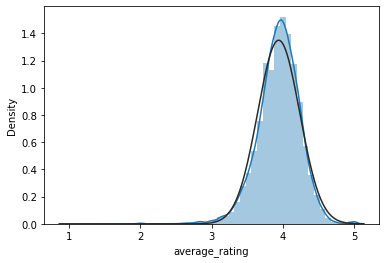

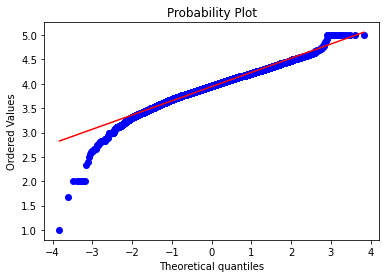

In [40]:
# пример визуального определения нормальности распределения

sns.distplot(db['average_rating'], fit=norm)
fig = plt.figure()
res = stats.probplot(db['average_rating'], plot=plt)

Видим, что распределение оценок близко к нормальному распределению.

Подробнее про квантиль-квантильные графики [pg.qqplot](https://pingouin-stats.org/generated/pingouin.qqplot.html#pingouin.qqplot)

Ниже мы применим тест Шапиро. Давайте предварительно опишем этот тест.

См. подробнее [здесь](https://pingouin-stats.org/generated/pingouin.normality.html?highlight=shapiro)

In [41]:
# теперь используем статистические тесты на нормальность распределения

stats.shapiro(db['average_rating']) # тест на нормальность Шапиро

C:\Users\runaz\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9734746217727661, pvalue=1.3771961307384302e-40)

Давайте на этом примере еще раз разберем, что же означает применение статанализа. Мы вычисляем интересующую нас статистику (в данном случае - Шапиро) и проверям нулевую гипотезу. Например, здесь нулевая гипотеза: данные распределены нормально. Так как pvalue < 0.05 (обратите внимание на экспоненциональную форму вывода "e-40"), мы должны отвергнуть нулевую гипотезу и принять альтернативную, то есть мы отвергаем гипотезу, что данные распределены нормально, и принимаем гипотезу, что данные не распределены нормально. Такой результат называется статистически значимым. Возможно применение и иных методов: тест на нормальность D'Agostino-Pearson, тест Колмагорова-Смирнова.

Итак, данные не распределены нормально. В это случае мы можем применить непараметрические тесты, например корреляцию Спирмена или перестановочный тест (пермутацию).

Обратите внимание, что ниже я буду использовать библиотеку [pingouin](https://pingouin-stats.org/generated/pingouin.normality.html?highlight=shapiro). Данная библиотека основа на Statsmodels, которая считается стандартом, однако предоставляет более удобный вывод результатов тестов, а также дополнительные тесты. 

Для определения нормального распределения можно также применять показатели skew и kurtosis.

Если skew положителен, то данные скошены вправо, а если отрицателен то влево. Если kurtosis положителен, то распределение имеет острую вершину, если отрицатеьный то распределение имеет пологую вершину. Нормальное распределение имеет скошенность 0 и вершину около 3. Эксцесс-это статистическая мера, которая определяет, насколько сильно хвосты распределения отличаются от хвостов нормального распределения. Другими словами, эксцесс определяет, содержат ли хвосты данного распределения экстремальные значения.

**Внимание!** 

Если предположения о нормальности или однородности дисперсий не выполняются, то можно преобразовать данные таким образом, чтобы они соответствовали нормальным. В этом случае важно помнить, что интерпретация результатов теста требует выполнения обратных преобразований данных. Некоторые преобразования данных по-разному влияют на нормальность и дисперсию, поэтому следует проверять различные преобразования. Есть, конечно, общие преобразования, которые используются. О них мы поговорим ниже.


In [42]:
# корреляция один против всех по Спирмену

pg.pairwise_corr(db, columns=[['average_rating'], ['num_pages', 'ratings_count', 'text_reviews_count']], method='spearman', padjust='bonf') 

,X,Y,method,alternative,n,r,CI95%,p-unc,p-corr,p-adjust,power
0,average_rating,num_pages,spearman,two-sided,10838,0.119,"[0.1, 0.14]",0.000,0.000,bonf,1.000
1,average_rating,ratings_count,spearman,two-sided,10838,0.086,"[0.07, 0.1]",0.000,0.000,bonf,1.000
2,average_rating,text_reviews_count,spearman,two-sided,10838,0.030,"[0.01, 0.05]",0.002,0.005,bonf,0.887


Мы построили таблицу корреляции "один против всех", когда один признак **average_rating** проверяется на корреляцию со всеми остальными. Давайте разберемся, что означает каждый показатель.
* **n** это количество наблюдений (строк), которые учитывались при построении корреляции;
* **r** это коэффициент корреляции по Спирмену. Хорошее объяснение можно найти в кнгие Статистика для всех Сары Бослаф. Мы видим, что корреляция слабая. Возможно только, что количество страниц связано положительной корреляцией с оценкой, то есть уменьшение количества страниц ведет к уменьшению оценки, увеличение - к увеличению;
* **CI95%** это доверительный интервал для r. Важно помнить, что во всех случаях, когда это позволяют статистические тесты, результаты таких тестов необходимо приводить с доверительными интервалами;
* **r2** это коэффициент детерминации, то есть какя доля дисперсии average_rating может быть объяснена другим признаком;
* **z** это стандартизированная оценка корреляции;
* **p-unc** это не скорректированная оценка p-value;
* **p-corr** это скорректированная оценка p-value;
* **p-adjust*** это поправка, которую применили к p-value. В данном случае Бонферрони;
* **power** это мощность, то есть 1 минус вероятность допустить ошибку 2 типа (нулевая гипотеза на самом деле ложна, но мы не смогли ее отвергнуть). Другими словами вероятность обнаружения существующей закономерности.

*Выводы*

Мы получили корреляцию между **average_rating** и числовыми признаками. Наш вывод следующий: средняя оценка не имеет значимых связей с другими количественными данными. Кажется, что мы не достигли никакого результата? Это не так. Во-первых, отсутствие сильной корреляции пригодится нам при машинном обучении. Во-вторых, мы установили, например, что от количества страниц в книге оценка не зависит. В тоже время зависимость от количества страниц все же выше, чем от количества оценок или количества обзоров. Другими словами, желание читателей оставить отзыв не коррелирует с оценкой.

Остается вопрос, а как быть с категориальными признакми? Здесь нам понадобится дисперсионный анализ. Но давайте сначала визуализируем корреляцию.

<AxesSubplot:>

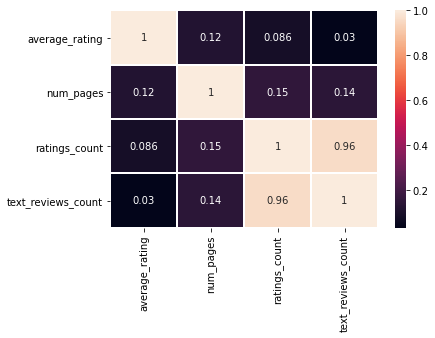

In [43]:
# визуализация корреляции

sns.heatmap(db.corr(method='spearman'), annot=True, linewidths=1)

### Дисперсионный анализ

Мы проверим четыре предположения: 

1) на среднюю оценку влияет наличие или отсутствие соавтора/переводчика; 
2) на среднюю оценку влияет декада; 
3) на среднюю оценку влияет квартал, в котором издана книга; 
4) на среднюю оценку влияет многотомность издания.

Мы проведем тест ANOVA, который также называется дисперсионным анализом. Опишем этот анализ так, как уже принято.

*Общие условия применения теста ANOVA*

1) выборки независимые; 
2) зависимая переменная нормально распределена; 
3) соблюдается равенство дисперсий. Мы уже знаем, что нормального распределения у нас нет. Ниже проверим еще равенство дисперсий.

*Дисперсионный анализ однофакторный*

*Когда применяется*

Проверка средних значений определенной переменной в двух и более группах. Смысл текста таков. Тест проверяет общую разницу между переменными в модели, то есть что по крайней мере одна из групп статистически значимо отличается от других. Однако, если ANOVA значима, нельзя сказать, какие группы отличаются. Чтобы определить, какие группы отличаются друг от друга, необходимо провести плановые или послеплановые сравнения. Например, можно применить апостериорный тест Шеффа для отбора групп.

*Условия применения теста*

1) зависимая переменная – непрерывная, факторы – дихотаматические или категориальные. Если некоторые перменные являются категориальными, а другие непрерывными, то анализ называется анализом ковариации (ANCOVA, см. ниже); 
2) каждое значение зависимой переменной не должно зависеть от других ее значений; 
3) нормальное распределение зависимой переменной. Для данного теста предположение о нормальности распределения проверяется на остатках; 
4) однородность дисперсии.

*Альтернативы, если условия не выполняются*

Непараметрический тест Краскела-Уоллиса

*Формула* 

См. подробнее [здесь](https://www.pythonfordatascience.org/anova-python/)

*Интерпретация*

См. подробнее [здесь](https://www.pythonfordatascience.org/anova-python/)

*Особенности*

При проведении ANOVA с несколькими факторами, как в нашем случае, все факторы должны быть проверены на взаимодействие, прежде чем рассматривать их индивидуальные основные эффекты. Если взаимодействие между переменными несущественно, то надо удалить переменные из взаимодействия и провести анализ снова. 


*Дисперсионный анализ. Многофакторный*

*Когда применяется?*

Если есть 2 и более фактора.

*Условия применения теста*

Как в однофакторном

*Особенности*

Нулевая гипотеза: нет разницы для зависимой переменной от фактора (взаимодействия факторов)


*ANCOVA*

*Когда применяется?*

Если один из факторов – непрерывная переменная.

*Условия применения теста* 

Как обычная ANOVA плюс:
1) независимость ковариант и эффектов фактора. Проверяется по ANOVA; 
2) однородность регрессионных наклонов. Определяется по графику.

In [44]:
# проверка на равенство дисперсий, тест Левена

pg.homoscedasticity(db, dv='average_rating', group='tra_co') 

,W,pval,equal_var
levene,0.385,0.535,True


Если в тесте Левина pvalue > 0.0, то не отвергаем нулевую гипотезу: дисперсии равны. Мы принимаем нулевую гипотезу о равенстве дисперсий, так как p-value > 0.05. Однако данные распределены не нормально, поэтому применить параметрический тест нельзя. Нужна непараметрическая проверка. Воспользуемся, например, перестановочным тестом. 

Смысл перестановочного теста в следующем. Нам надо посчитать различаются ли средние между группами в признаке. Мы считаем эту разницу на фактических данных. Далее, мы перемешиваем данные по группам, выделяем из этих данных новые две группы, считаем статистику на них. Так мы делаем, например, 10000 раз. Получаем 10000 значений статистики. Смотрим, сколько раз в этом списке полученных значений встречалось наше изначальное значение. Вычисляем вероятность. Если p-value было меньше 0.05, то это означает, что случайно получить разницу средних маловероятно, а значит эта разница носит не случайный характер.

In [45]:
# влияет ли наличие соавтора/переводчика на среднюю оценку?

p_value = permutation_test(db[db['tra_co']=='0']['average_rating'], db[db['tra_co']=='1']['average_rating'], method='approximate', num_rounds=10000, seed=0) 
p_value

9.999000099990002e-05

Мы видим, что p-value меньше 0.05, поэтому отвергаем нулевую гипотезу о равенстве средних. Принимаем альтернативную гипотезу о том, что средние не равны. Значит для книг с переводчиком оценка отличается от книг без переводчиков. Это же мы можем проверить с помощью дисперсионного анализа, который затем нам пригодится и для ответа на другие вопросы. У нас выполняются не все условия для классической ANOVA, поэтому применим непараметрический тест Велча. Но прежде опишем этот тест.

См. подробнее [здесь](https://pingouin-stats.org/generated/pingouin.welch_anova.html?highlight=welch#pingouin.welch_anova)

In [46]:
# тест Велча

aov_W = welch_anova(dv='average_rating', between = 'tra_co', data=db)
aov_W 

,Source,ddof1,ddof2,F,p-unc,np2
0,tra_co,1,9265.317,91.503,0.000,0.008


Нулевая гипотеза: средние оценки для книг с соавторами/переводчиками и без них равны. Мы видим, что p-value (без корректировки) у нас 0.00, значит мы должны отвергнуть нулевую гипотезу и принять альтернативную: средние неравны. Здесь нам нет смысла искать между какими группами есть отличия, так как таких групп всего две. Но давайте ответим на следующие вопросы.

In [47]:
# влияние декады на среднюю оценку

aov_W1 = welch_anova(dv='average_rating', between = 'decade', data=db) 
aov_W1

,Source,ddof1,ddof2,F,p-unc,np2
0,decade,7,190.451,3.595,0.001,0.002


Отвергаем нулевую гипотезу о равенстве средних. Принимаем гипотезу, что средние неравны. Другими словами, средняя оценка зависит от декады, в которой вышла книга.

In [48]:
# влияние квартала на среднюю оценку

aov_W2 = welch_anova(dv='average_rating', between = 'quarter', data=db)
aov_W2

,Source,ddof1,ddof2,F,p-unc,np2
0,quarter,3,6003.618,4.802,0.002,0.001


Отвергаем нулевую гипотезу о равенстве средних и принимаем альтернативную гипотезу. Другими словами, средняя оценка зависит от квартала, в котором вышла книга. Здесь посмотрим, между какими кварталами есть разница.

In [49]:
pg.pairwise_gameshowell(data=db, dv='average_rating', between='quarter') 

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,1,2,3.940,3.926,0.014,0.008,1.722,5263.419,0.313,0.047
1,1,3,3.940,3.945,-0.005,0.008,-0.575,5353.146,0.900,-0.016
2,1,4,3.940,3.957,-0.016,0.008,-1.998,5267.451,0.189,-0.055
3,2,3,3.926,3.945,-0.019,0.008,-2.347,5529.298,0.088,-0.063
4,2,4,3.926,3.957,-0.030,0.008,-3.746,5418.750,0.001,-0.102
5,3,4,3.945,3.957,-0.012,0.008,-1.473,5541.215,0.455,-0.039


Видим, что разница есть между вторым и четвертым кварталом (p-value = 0.001).

In [50]:
aov_W3 = welch_anova(dv='average_rating', between = 'multivolume', data=db)
aov_W3

,Source,ddof1,ddof2,F,p-unc,np2
0,multivolume,1,5170.478,121.354,0.000,0.010


Видим, что средняя оценка зависит от многотомности издания.

Выводы
1) На среднюю оценку слабо влияют количественные признаки из наших данных, в том числе количество страниц в книге. 
2) На среднюю оценку влияют категориальные данные, а именно наличие или отсутствие соавтора/переводчика, декада, в которой вышла книга, квартал, в котором вышла книга, а также многотомность издания. 

Теперь мы изучим названия книг, получим для них количественные характеристики и посмотрим, как они влияют на оценку книги. После этого наш анализ будет завершен.

# Анализ названий книг

В этом разделе мы проанализируем названия книг. Для этого мы применим NLTK и базовые принципы работы с естественным языком. 

Прежде мы должны заметить вот что. В **title** у нас часто задано не только название книги, но и какая-то характеристика в скобках. Посмотрим на это.

In [51]:
# экранируем скобку, иначе код выдаст ошибку

db[db['title'].str.contains('\(')] 

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume
0,Harry Potter and the Half-Blood Prince (Harry ...,4.570,eng,652,2095690,27591,2000,3,1,1
1,Harry Potter and the Order of the Phoenix (Har...,4.490,eng,870,2153167,29221,2000,3,1,1
2,Harry Potter and the Chamber of Secrets (Harry...,4.420,eng,352,6333,244,2000,4,0,1
3,Harry Potter and the Prisoner of Azkaban (Harr...,4.560,eng,435,2339585,36325,2000,2,1,1
4,Harry Potter Boxed Set Books 1-5 (Harry Potte...,4.780,eng,2690,41428,164,2000,3,1,1
...,...,...,...,...,...,...,...,...,...,...
10828,O Cavalo e o Seu Rapaz (As Crónicas de Nárnia ...,3.920,por,160,207,16,2000,3,1,1
10829,O Sobrinho do Mágico (As Crónicas de Nárnia #1),4.040,por,147,396,37,2000,2,1,1
10830,A Viagem do Caminheiro da Alvorada (As Crónica...,4.090,por,176,161,14,2000,3,1,1
10831,O Príncipe Caspian (As Crónicas de Nárnia #4),3.970,por,160,215,11,2000,4,1,1


Удалим скобки, но работать будем только с копией таблицы, так как то, что в скобках, само по себе важный признак. Нас же здесь просто интересует название книги.

In [52]:
db_copy = db.copy() 

In [53]:
# применяем регулярное выражение, чтобы найти скобки и удалить их

db_copy['title'] = db_copy['title'].str.replace(r"\(.*\)", "") 

<ipython-input-53-ecc7e6968db7>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  db_copy['title'] = db_copy['title'].str.replace(r"\(.*\)", "")


In [54]:
db_copy.head() 

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume
0,Harry Potter and the Half-Blood Prince,4.570,eng,652,2095690,27591,2000,3,1,1
1,Harry Potter and the Order of the Phoenix,4.490,eng,870,2153167,29221,2000,3,1,1
2,Harry Potter and the Chamber of Secrets,4.420,eng,352,6333,244,2000,4,0,1
3,Harry Potter and the Prisoner of Azkaban,4.560,eng,435,2339585,36325,2000,2,1,1
4,Harry Potter Boxed Set Books 1-5,4.780,eng,2690,41428,164,2000,3,1,1


In [55]:
# смотрим количество символов в названии книг

db_copy['title'].str.len().sort_values(ascending=False)[:5] 

7242    254
9527    210
2711    209
826     202
5962    198
Name: title, dtype: int64

In [56]:
# посмотрим книги с самым длинным названием

db_copy[db_copy['title'].str.len() > 200] 

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume
826,Christian Mythmakers: C.S. Lewis Madeleine L'...,3.930,eng,303,448,18,2000,4,1,0
2711,Dr. Mary's Monkey: How the Unsolved Murder of ...,3.920,eng,374,1023,164,2000,2,1,0
7242,Yours in Food John Baldessari: with meditatio...,4.000,en-US,144,19,4,2000,3,1,0
9527,The covert war against rock: what you don't kn...,3.580,eng,280,85,8,2000,2,0,0


In [57]:
# создадим признак по длине названия

db_copy['len_title'] = db_copy['title'].str.len() 

In [58]:
db_copy.head()

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title
0,Harry Potter and the Half-Blood Prince,4.570,eng,652,2095690,27591,2000,3,1,1,39
1,Harry Potter and the Order of the Phoenix,4.490,eng,870,2153167,29221,2000,3,1,1,42
2,Harry Potter and the Chamber of Secrets,4.420,eng,352,6333,244,2000,4,0,1,40
3,Harry Potter and the Prisoner of Azkaban,4.560,eng,435,2339585,36325,2000,2,1,1,41
4,Harry Potter Boxed Set Books 1-5,4.780,eng,2690,41428,164,2000,3,1,1,34


In [59]:
# объединим все названия в один список

title_list = list(db_copy['title'])

In [60]:
# проверям длину списка, чтобы она была равна количеству из таблицы

len(title_list) 

10838

In [61]:
# объединим в один текст

text = ' '.join(title_list) 

In [62]:
# определяем количество слов

words = re.findall('\w+', text) 
len(words)

56639

In [63]:
# количество уникальных слов

len(set(words)) 

10802

In [64]:
(len(set(words)) / len(words)) * 100

19.071664400854534

Мы видим, что уникальные слова составляют только 19% от всех слов в названиях. Много это или мало? При работе с другими текстами я встречал, например, 5%. И это были вполне классические книги. Так что можно полагать, что названия книг достаточно разнообразны. Но давайте теперь посмотрим, насколько длинные слова используют в названиях книг.

In [65]:
x = [len(w) for w in words ]

In [66]:
fdist = nltk.FreqDist(x)
fdist.tabulate()

    3     5     4     2     6     7     8     1     9    10    11    12    13    14    15    17    16    18 
11606  7567  7542  6669  5947  5078  3448  3335  2468  1480   665   429   300    68    18    10     8     1 


Мы видим, что слова в основном короткие - три знака. Хорошо, теперь давайте еще раз проведем деление на слова (токенизацию), но уже другим способом.

In [67]:
# токенизация с помощью NLTK

tokenizer = RegexpTokenizer('\w+')
tokens = tokenizer.tokenize(text)

In [68]:
tokens[:10]

['Harry',
 'Potter',
 'and',
 'the',
 'Half',
 'Blood',
 'Prince',
 'Harry',
 'Potter',
 'and']

In [69]:
# убираем заглавные буквы. При этом надо помнить, что мы теряем информацию об имени и т.п.

words = []

for word in tokens:
    words.append(word.lower()) 

In [70]:
words[:10]

['harry',
 'potter',
 'and',
 'the',
 'half',
 'blood',
 'prince',
 'harry',
 'potter',
 'and']

In [71]:
# загружаем стоп-слова и дополняем список

sw = nltk.corpus.stopwords.words('english') 
sw.extend(['vol', '1', '2', 'volume', 'la', 'de']) 

In [72]:
# убираем стоп-слова

words_ns = []

for word in words:
    if word not in sw:
        words_ns.append(word)

In [73]:
# исчезло, например, and

words_ns[:10] 

['harry',
 'potter',
 'half',
 'blood',
 'prince',
 'harry',
 'potter',
 'order',
 'phoenix',
 'harry']

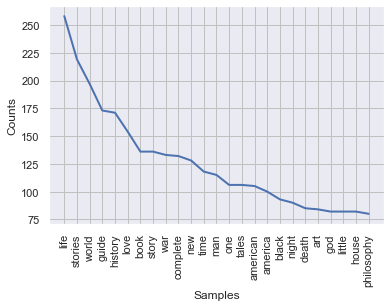

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [74]:
#задаем стиль графика

sns.set() 
freq = nltk.FreqDist(words_ns)
freq.plot(25)

Теперь мы хотим произвести теже операции, но на датафрейме, чтобы получить дополнительные признаки. Здесь мы также увидим, как применяется лямбда функция, в том числе совместно с генератором

In [75]:
db_copy['title'] = db_copy['title'].apply(lambda x: tokenizer.tokenize(x)) 
db_copy['title'] = db_copy['title'].apply(lambda x: " ".join(x for x in x if x not in sw)) 
db_copy['title'] = db_copy['title'].str.lower()

In [76]:
db_copy.head() 

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title
0,harry potter half blood prince,4.570,eng,652,2095690,27591,2000,3,1,1,39
1,harry potter order phoenix,4.490,eng,870,2153167,29221,2000,3,1,1,42
2,harry potter chamber secrets,4.420,eng,352,6333,244,2000,4,0,1,40
3,harry potter prisoner azkaban,4.560,eng,435,2339585,36325,2000,2,1,1,41
4,harry potter boxed set books 5,4.780,eng,2690,41428,164,2000,3,1,1,34


In [77]:
# функция для оценки эмоций

def senti(data): 
    return TextBlob(data).sentiment

In [78]:
# эмоциональность названия книги

db_copy['polarity'] = db_copy['title'].apply(lambda x: TextBlob(x).sentiment.polarity) 

In [79]:
# субъективность названия книги

db_copy['subjectivity'] = db_copy['title'].apply(lambda x: TextBlob(x).sentiment.subjectivity) 

In [80]:
db_copy.head(20)

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity
0,harry potter half blood prince,4.570,eng,652,2095690,27591,2000,3,1,1,39,-0.167,0.167
1,harry potter order phoenix,4.490,eng,870,2153167,29221,2000,3,1,1,42,0.000,0.000
2,harry potter chamber secrets,4.420,eng,352,6333,244,2000,4,0,1,40,0.000,0.000
3,harry potter prisoner azkaban,4.560,eng,435,2339585,36325,2000,2,1,1,41,0.000,0.000
4,harry potter boxed set books 5,4.780,eng,2690,41428,164,2000,3,1,1,34,0.000,0.000
5,unauthorized harry potter book seven news half...,3.740,en-US,152,19,1,2000,2,0,0,87,-0.167,0.167
6,harry potter collection,4.730,eng,3342,28242,808,2000,3,0,1,24,0.000,0.000
7,the ultimate hitchhiker guide five complete no...,4.380,eng,815,3628,254,2000,4,0,1,68,0.050,0.700
8,the ultimate hitchhiker guide galaxy,4.380,eng,815,249558,4080,2000,2,0,1,46,0.000,1.000
9,the hitchhiker guide galaxy,4.220,eng,215,4930,460,2000,3,0,1,37,0.000,0.000


Две оценки (-0.5, 0.875) означают: первая негативный/позитивный заголовок (от -1 до 1, ближе к 1 позитивный, ближе к -1 негативный, 0 нейтральный), вторая объективный/субъективный (от 0 до 1, ближе к 1 субъективный).

Мы получили три новых признака: длина названия, эмоциональная окраска, субъективность. Давайте теперь применим статистический анализ. У нас только количественные признаки, установить мы хотим корреляцию. У нас нет нормального распределения в **average_rating**. Поэтому мы применим корреляцию Спирмена. 

*Корреляция Спирмена*

*Когда применяется*

Если не выполняются условия для корреляции Пирсона.

*Условия применения теста*

*Альтернативы, если условия не выполняются*

1) гамма Гудмана и Краскелла; 
2) тау Кендела; 
3) d Сомерса.

*Формула*


*Интерпретация*

Нулевая гипотеза: среднее выборки равно среднему совокупности; среднее выборок равны. Чем ближе к 1, тем сильнее связь.


*Особенности*


In [81]:
# корреляция один против всех по Спирмену

pg.pairwise_corr(db_copy, columns=[['average_rating'], ['len_title', 'polarity', 'subjectivity']], method='spearman', padjust='bonf') 

,X,Y,method,alternative,n,r,CI95%,p-unc,p-corr,p-adjust,power
0,average_rating,len_title,spearman,two-sided,10838,0.163,"[0.14, 0.18]",0.000,0.000,bonf,1.000
1,average_rating,polarity,spearman,two-sided,10838,0.034,"[0.01, 0.05]",0.000,0.001,bonf,0.938
2,average_rating,subjectivity,spearman,two-sided,10838,0.035,"[0.02, 0.05]",0.000,0.001,bonf,0.953


Мы видим, что нет слабой корреляции ни с одним признаком. Давайте еще создадим облако слов для книг с положительными и отрицательными оценками. На этом мы и закончим.


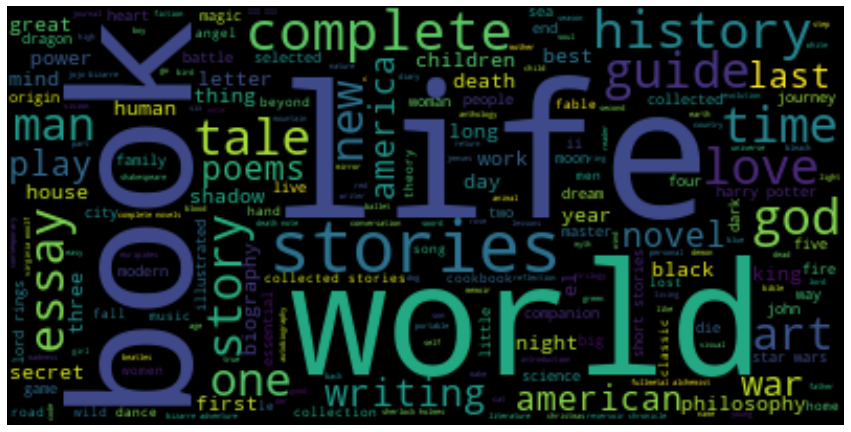

In [82]:
db_copy['rating'] = db_copy['average_rating'].apply(lambda rating: 'positive' if rating >=4 else 'negative')
positive = db_copy[db_copy['rating'] == 'positive']
negative = db_copy[db_copy['rating'] == 'negative']
pos = " ".join(x for x in positive['title'])
wordcloud1 = WordCloud(stopwords=sw).generate(pos) 
fig, ax = plt.subplots(figsize = (15, 10))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

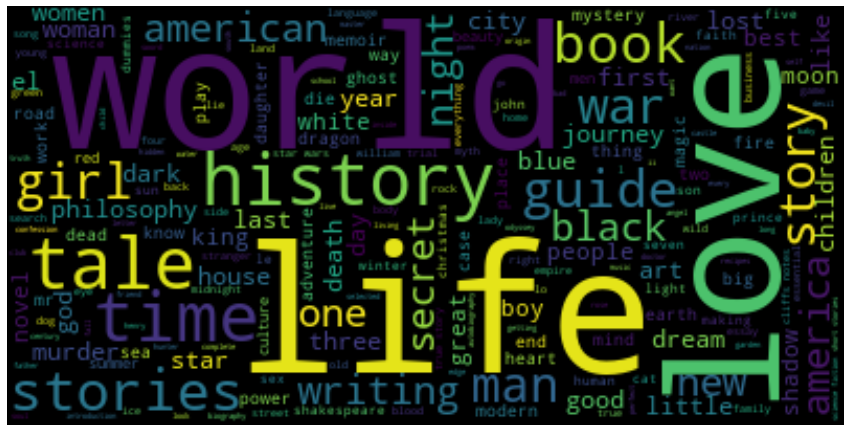

In [83]:
neg = " ".join(x for x in negative['title'])
wordcloud2 = WordCloud(stopwords=sw).generate(neg) 
fig, ax = plt.subplots(figsize = (15, 10))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

Сохраним нашу таблицу и дальше будем работать только с ней.

# Сохранение обогащенных данных

In [84]:
db_copy = db_copy.drop('rating', axis=1)
db_copy.to_csv('gd_augmentation.csv', index=False) 

In [85]:
db_copy.head()

,title,average_rating,language_code,num_pages,ratings_count,text_reviews_count,decade,quarter,tra_co,multivolume,len_title,polarity,subjectivity
0,harry potter half blood prince,4.570,eng,652,2095690,27591,2000,3,1,1,39,-0.167,0.167
1,harry potter order phoenix,4.490,eng,870,2153167,29221,2000,3,1,1,42,0.000,0.000
2,harry potter chamber secrets,4.420,eng,352,6333,244,2000,4,0,1,40,0.000,0.000
3,harry potter prisoner azkaban,4.560,eng,435,2339585,36325,2000,2,1,1,41,0.000,0.000
4,harry potter boxed set books 5,4.780,eng,2690,41428,164,2000,3,1,1,34,0.000,0.000


# Приложение

В этом приложении собраны некоторые общие рекомендации, в том числе по выбору статистических тестов, а также приведены описания тестов, которые не нашли места в основном тексте главы, но широко применяются.

## Общие рекомендации

Как указывалось выше, тесты могут быть разделены на параметрические и непараметрические. К непараметрическим относятся также тесты с перестановкой (пермутацией). При этом надо различать пермутацию и бутстрап. Пермутация - это выборка без возвращения. Бутстрап - выборка с возвращением. Бутстрап применяют при наличии сильных выбросов и для определения надежности оценки, то есть для доверитальных интервалов.

Непараметрические тесты считаются менее надежными, чем параметрические, за исключением тестов с перестановкой.

Параметрические тесты требуют соблюдения следующих условий:

1) независимость выборок; 
2) нормальное распределение в генеральной совокупности; 
3) равенство дисперсий в выборках.

В том случае, если данные не соответсвуют нормальному распределению, можно выполнить следующее:

1) преобразовать данные таким образом, чтобы они соответствовали нормальному распределению (например, воспользоваться преобразованием Бокса-Кокса);
2) применить непараметрические тесты;
3) положиться на центральную предельную теорему, если выборка значительная, то есть принять, что данные все-таки нормально распределены (другими словами - проигнорировать результаты теста).

Проверка дисперсии может быть осуществлена с помощью:

1) теста Барлетта. Чувствителен к отклонению данных от нормального распределения, поэтому при наличии таких отклонений применяется с осторожностью;
2) тест Левена. Менее чувствителен к отклонениям данных от нормального распределения.

Если условие по дисперсии не выполняется то можно:

1) применить непараметрический тест, например t-тест Вэлча;
2) изменить данные.

При проведении тестов важное значение имеют нулевые гипотезы. Гипотезы бывают односторонние и двусторонние. Одностороняя гипотеза: А лучше В. Двусторонняя гипотеза: А отличается от B и может быть больше или меньше. 


Разница между дисперсией, ковариацией и корреляцией:

1) дисперсия - это мера изменчивости конкретного значения от среднего значения по всему набору данных;
2) ковариация - это мера взаимосвязи между изменчивостью двух переменных. Ковариация зависит от масштаба, поскольку она не стандартизирована;
3) корреляция - это связь между изменчивостью двух переменных. Корреляция стандартизирована, что делает ее не зависящей от масштаба.



## Процедура выбора теста

Приведенное ниже описание выбора тестов сделано на основании данных, взятых [отсюда](https://pingouin-stats.org/guidelines.html#correlation). 


**Выбор параметрического теста**

*Есть ли выбросы и(или) отсутствует нормальное распределение?*

Если нет выбросов и распределение нормальное, то применяем корреляцию по Пирсону. 

Если есть выбросы и(или) распределение не нормальное, то применяем корреляцию Спирмена. При этом, если univariate outliers, то применяем biweight midcorrelation или percentage bend correlation (эти методы указываются при вызове corr(method=”__”) из библиотеки pingouin).

Если же bivariate outliers, то применяем skipped correlation или Shepherd correlation.


**Выбор непараметрического теста**

*Сколько групп?*

*Если две, то надо решить группы парные или нет?*

Если не парные, то тест Манн-Уитни. Если же парные, то тест Вилкоксона.

*Если три и более группы, то надо решить, парные или нет?*

Если не парные, то тест Краскалла-Уоллса с постхок тестом.

*Если же парные, то надо решить, данные бинарные или нет?*

Если бинарные, то тест Кохрана. Если нет, то Фридмана.


**Выбор теста ANOVA**

*Если выборки независимы, то надо ответить на вопрос, дисперсии равны?*

Если да, то классическая ANOVA, апостериорный тест - тест Tukey-HSD. Если нет, то Welch ANOVA, апостериорный - тест Games-Howell.

Если выборки зависимые, то применяем repeated measure ANOVA, парный t-test.


## Тест Стьюдента

Один из самых широко применяемых тестов.

*Когда применяется?*

Проверка равенства средних значений двух выборок.


*Условия применения теста*

1) независимость выборок; 
2) нормальность распределения; 
3) равенство дисперсий

*Альтернативы, если условия не выполняются*
Непараметрические тесты, в том числе пермутация; тест Велча

*Формула*

См. подробнее [здесь](https://www.pythonfordatascience.org/independent-samples-t-test-python/)

*Интерпретация*

См. подробнее [здесь](https://www.pythonfordatascience.org/independent-samples-t-test-python/)


*Особенности*

См. подробнее [здесь](https://www.pythonfordatascience.org/independent-samples-t-test-python/)


## Хи квадрат

*Когда применяется?*

Для определения связи между двумя и более категориальными переменными.

*Условия применения теста*

1) независимость выборок; 
2) нет значений меньше 1; 
3) не более чем в 20% ячеек значения меньше 5.

*Альтернативы, если условия не выполняются*

Точный тест Фишера

*Формула*

См. подробнее [здесь](https://www.pythonfordatascience.org/chi-square-test-of-independence-python/)


*Интерпретация*

Нулевая гипотеза: переменные независимы.
Получаем статистику, если она значима, то есть pvalue < 0.05, то нулевую гипотезу отвергаем.


*Особенности*

Хи квадрат определяет только наличие или отсутствие зависимости между выборками. 
Силу корреляции между группами определяют по фи, коэффициента сопряжённости и V коэффициента Крамера.